<a href="https://colab.research.google.com/github/cgbas/tc-data-analytics/blob/feature%2Ffase2/fase%202/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo preditivo Ibovespa

Imagine que você foi escalado para um time de investimentos e precisará realizar um modelo preditivo com dados do IBOVESPA (Bolsa de Valores) para criar uma série temporal e prever diariamente o fechamento da base.

Para isso utilize a base  de dados contida no [Site da Investing](!https://br.investing.com/indices/bovespa-historical-data) e selecione o período diário, com o intervalo de tempo que achar adequado.

Você precisará demonstrar para o time de investimentos:

- O modelo com o storytelling, desde a captura do dado até a entrega do modelo;
- Justificar a técnica utilizada;
- Atingir uma acuracidade adequada (acima de 70%)

_Dica: utilize o maior intervalo de tempo possível para atingir maior acuracidade no modelo preditivo._

### Coleta e Tratamento dos dados

Consideraremos dados desde o primeiro dia do plano real (01/07/1994) em nossa análise preliminar, inclusive para entender a ocorrência de outliers desde a introdução de nossa moeda corrente.



In [1]:
#bibliotecas que vamos usar neste estudo
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df_ibovespa = pd.read_csv('/content/DadosHistoricosIbovespa_de_1995_ate_2024.csv', dtype=str, dayfirst=True, parse_dates=[0], index_col='Data') #importando os dados, importamos tudo como string para evitar perder os 0 (a esquerda e direita) dos números. E também já convertendo a coluna "Data" para o tipo datetime. Deixa a coluna data como o índice da tabela.
df_ibovespa.head() #verificando os dados

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2010-06-30,60.936,61.972,62.645,60.936,"1,96M","-1,68%"
2010-06-29,61.978,64.216,64.216,61.670,"2,20M","-3,50%"
2010-06-28,64.225,64.825,65.105,64.225,"943,30K","-0,92%"
2010-06-25,64.824,63.937,64.869,63.806,"1,26M","1,39%"
2010-06-24,63.937,65.154,65.154,63.736,"1,79M","-1,88%"


In [3]:
#Excluindo a coluna que não vamos usar para a análise
df_ibovespa.drop(columns=['Var%'], inplace=True)

#Renomeando as colunas restantes, para não termos problemas com funções futuras (pois tem acentos)
df_ibovespa.columns = ['Fechamento', 'Abertura', 'Maxima', 'Minima', 'VolumeNegociado']
df_ibovespa.head() #verificando sucesso das alterações

,Fechamento,Abertura,Maxima,Minima,VolumeNegociado
Data,,,,,
2010-06-30,60.936,61.972,62.645,60.936,"1,96M"
2010-06-29,61.978,64.216,64.216,61.670,"2,20M"
2010-06-28,64.225,64.825,65.105,64.225,"943,30K"
2010-06-25,64.824,63.937,64.869,63.806,"1,26M"
2010-06-24,63.937,65.154,65.154,63.736,"1,79M"


In [4]:
#Alterando os tipos dos dados
df_ibovespa['Fechamento'] = df_ibovespa['Fechamento'].str.replace('.', '').astype(int) # Convertendo a coluna para o tipo inteiro
df_ibovespa['Abertura'] = df_ibovespa['Abertura'].str.replace('.', '').astype(int) # Convertendo a coluna para o tipo inteiro
df_ibovespa['Maxima'] = df_ibovespa['Maxima'].str.replace('.', '').astype(int) # Convertendo a coluna para o tipo inteiro
df_ibovespa['Minima'] = df_ibovespa['Minima'].str.replace('.', '').astype(int) # Convertendo a coluna para o tipo inteiro
df_ibovespa['VolumeNegociado'] = df_ibovespa['VolumeNegociado'].str[:-1].str.replace(',', '.').astype(float) * df_ibovespa['VolumeNegociado'].str[-1:].map({'K':1000, 'M':1000000, 'B':1000000000}) #Convertendo de texto para número
df_ibovespa.head() #verificando o resultado

,Fechamento,Abertura,Maxima,Minima,VolumeNegociado
Data,,,,,
2010-06-30,60936,61972,62645,60936,1960000.0
2010-06-29,61978,64216,64216,61670,2200000.0
2010-06-28,64225,64825,65105,64225,943300.0
2010-06-25,64824,63937,64869,63806,1260000.0
2010-06-24,63937,65154,65154,63736,1790000.0


# Análise exploratória

In [5]:
#Verificando a quantidade de linhas que temos para a análise (linhas, colunas)
df_ibovespa.shape

(7439, 5)

In [6]:
#estatísticas básicas do nosso dataframe
df_ibovespa.describe()

,Fechamento,Abertura,Maxima,Minima,VolumeNegociado
count,7439.000000,7439.000000,7439.000000,7439.000000,7.438000e+03
mean,50111.120177,50095.360532,50600.950262,49595.968813,1.597423e+09
std,36327.662752,36319.405200,36602.815645,36038.073257,3.909850e+09
min,2138.000000,2138.000000,2449.000000,2110.000000,1.121000e+05
25%,14047.500000,14048.000000,14219.500000,13854.500000,3.560000e+06
50%,50518.000000,50511.000000,51171.000000,50005.000000,1.150000e+07
75%,68618.500000,68607.500000,69304.500000,68026.500000,2.760725e+08
max,134194.000000,134194.000000,134392.000000,133832.000000,5.406000e+10


In [7]:
#verificando quantidade de dados nulos
df_ibovespa.isnull().sum()

Fechamento         0
Abertura           0
Maxima             0
Minima             0
VolumeNegociado    1
dtype: int64

<Axes: >

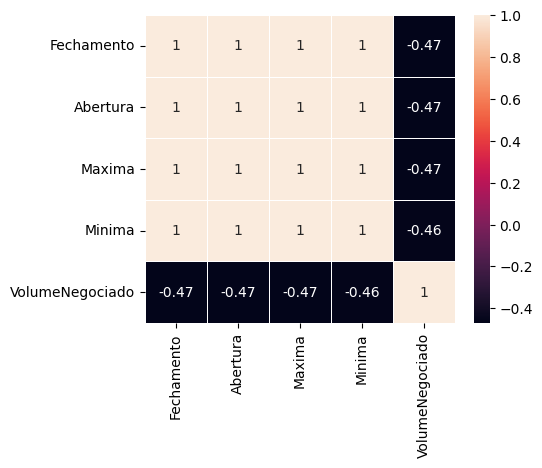

In [8]:
#Criando um gráfico de correlação para entendermos se as colunas tem algum tipo de correlação
dados_correlacao = df_ibovespa.select_dtypes(include=['int64', 'float64']) #Selecionando apenas as colunas que tem números
correlation_matrix = dados_correlacao.corr().round(2) #Criando a matriz de correlação
fig, ax = plt.subplots(figsize=(5, 4)) #indica o tamanho do gráfico
sns.heatmap(data=correlation_matrix, annot=True, linewidths=.5, ax=ax) #criando o gráfico de correlação

#Visualizando valores de fechamento

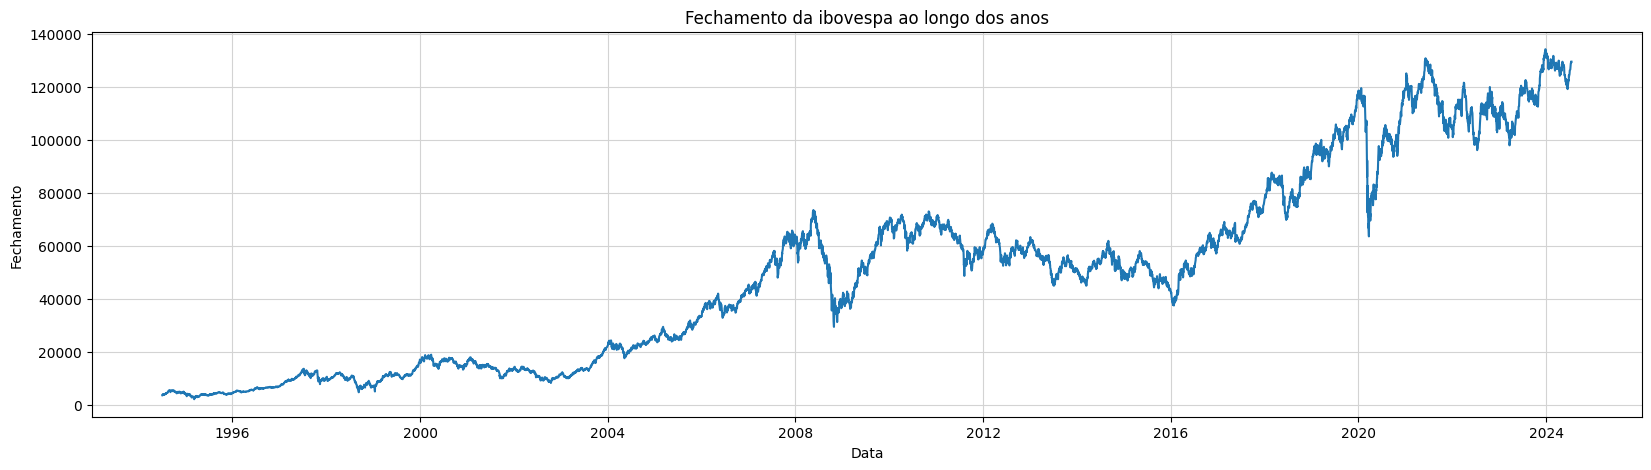

In [9]:
#Vamos analisar a variação do valor de fechamento ao longo dos anos
#Criando o gráfico de linhas para analisar se temos grandes mudanças ao longo do tempo na média de segundos ativos no checkout
fig, ax = plt.subplots(figsize=(20, 5)) #indica o tamanho do gráfico
ax.grid(True, color='lightgray') #Coloca as linhas de grade
sns.lineplot(x='Data', y='Fechamento', data=df_ibovespa) #cria o gráfico de linhas
ax.set_title('Fechamento da ibovespa ao longo dos anos') #título do gráfico
plt.show() #mostrando o gráfico

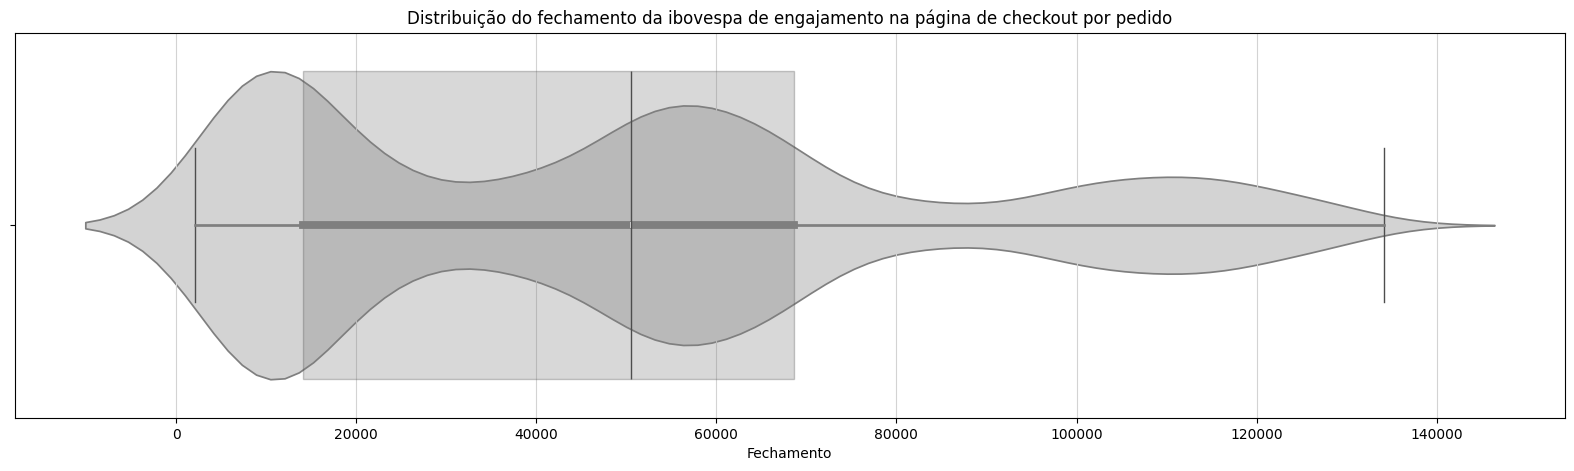

In [10]:
#Vamos analisar a distribuição desses dados com o violinplot, mesclado com o boxplot
fig, ax = plt.subplots(figsize=(20,5)) #indica o tamanho do gráfico
ax.grid(True, color='lightgray') #Coloca as linhas de grade
sns.boxplot(data=df_ibovespa, x='Fechamento', color='gray', boxprops=dict(alpha=.3)) #criando o boxplot
sns.violinplot(data=df_ibovespa, x='Fechamento', color='lightgray') #criando o violinplot
ax.set_title("Distribuição do fechamento da ibovespa de engajamento na página de checkout por pedido") #Título do gráfico
plt.show() #mostrando o gráfico

Como podemos ver, nossos dados são muito distantes entre si, por conta do grande período da nossa série temporal. Vamos fazer uma decomposição desses dados. Para que possamos analisar:
- Tendencia
- Sazonalidade
- Ruído

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [12]:
df_ibovespa_limpo = df_ibovespa.copy() #cópia do dataframe
df_ibovespa_limpo = df_ibovespa_limpo[['Fechamento']] #Pegando apenas colunas que vamos usar
df_ibovespa_limpo #verificando sucesso

,Fechamento
Data,
2010-06-30,60936
2010-06-29,61978
2010-06-28,64225
2010-06-25,64824
2010-06-24,63937
...,...
2010-07-07,63284
2010-07-06,62065
2010-07-05,60865


In [13]:
resultados = seasonal_decompose(df_ibovespa_limpo, model='multiplicative', period=5) #escolhida decomposição de 5 períodos pois foram uma semana (seg a sex).

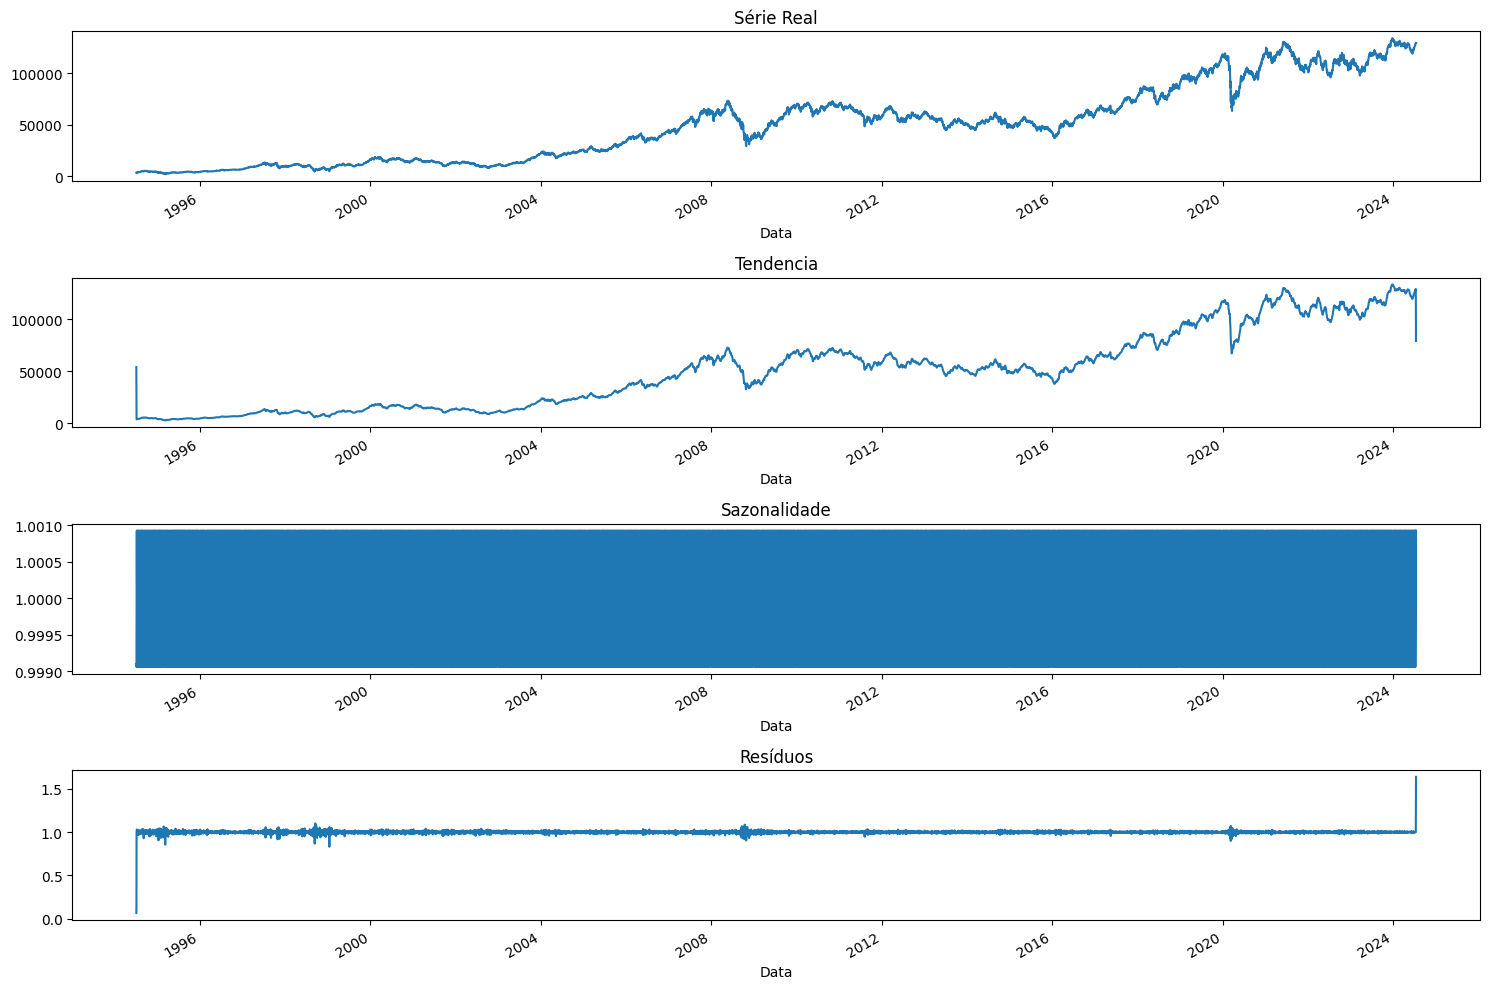

In [14]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10)) #cria as 4 figuras para plotarmos os gráficos
resultados.observed.plot(ax=ax1) #serie real
ax1.set_title('Série Real') #título do eixo 1
resultados.trend.plot(ax=ax2) #tendencia
ax2.set_title('Tendencia') #título do eixo 2
resultados.seasonal.plot(ax=ax3) #sazonalidade
ax3.set_title('Sazonalidade') #título do eixo 3
resultados.resid.plot(ax=ax4) #residuos
ax4.set_title('Resíduos') #título do eixo 4

plt.tight_layout() #Ajusta o padding entre os gráficos
plt.show() #mostrando os gráficos

Como podemos ver nos dados acima, os dados de fechamento da b3 tem uma ampla sazonalidade, o que dificulta a previsão de valores.

Também, a tendência do valor de fechamento fica bem voltada para cima, pois estamos comparando um período muito distante e com um valor de fechamento bem abaixo do que é realizado hoje em dia.

A partir do ano de 2021 nossos dados começam a ficar mais próximos da realidade que é hoje, antes disso tínhamos a pandemia da COVID-19 que fez com que os números de fechamento ficassem muito incertos, e ainda antes da pandemia nossos números eram baixos principalmente por conta da inflação e também por que tínhamos bem menos volume sendo negociado diariamente na bolsa de valores, confirmamos isso no gráfico abaixo:

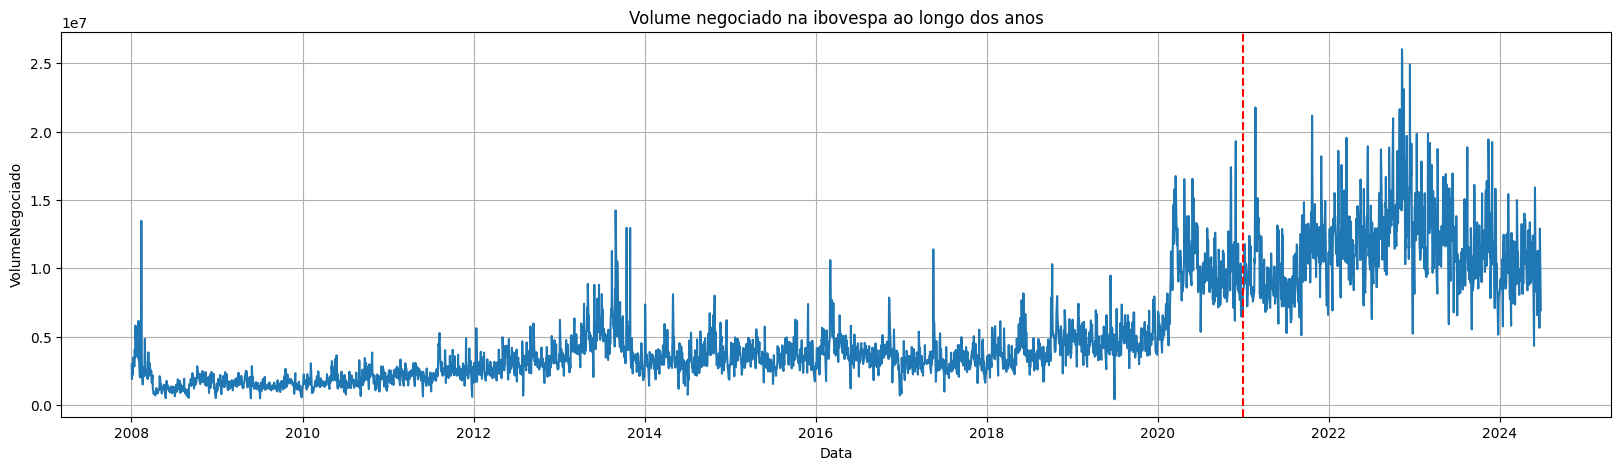

In [15]:
#Criando o gráfico de linhas para analisar os valores negociados na ibovespa
fig, ax = plt.subplots(figsize=(20, 5)) #indica o tamanho do gráfico
ax.grid(True) #Coloca as linhas de grade
sns.lineplot(data=df_ibovespa.loc['2008-01-02':'2024-06-25'], x='Data', y='VolumeNegociado') #cria o gráfico de linhas
ax.set_title('Volume negociado na ibovespa ao longo dos anos') #título do gráfico
ax.axvline(pd.Timestamp('2021-01-01'), color='red', linestyle='--') #adicionando uma linha vermelha a partir de 2021
plt.show() #mostrando o gráfico

Assim sendo resolvemos que o período a partir do dia 01/01/2021 será o ideal para nossas análises, pois é justamente o "início do fim" da pandemia, onde o mercado começou a ficar mais estável.

In [16]:
#Filtrando nossos dados para que sejam a partir da data 04/01/2021 (o primeiro dia de 2021 da nossa base)
df_ibovespa = df_ibovespa['2021-01-04':]

Agora vamos fazer a decomposição dos dados novamente

In [17]:
df_ibovespa_limpo = df_ibovespa.copy() #cópia do dataframe
df_ibovespa_limpo = df_ibovespa_limpo[['Fechamento']] #Pegando apenas colunas que vamos usar

In [18]:
resultados = seasonal_decompose(df_ibovespa_limpo, model='multiplicative', period=2) #dessa vez escolhemos fazer a decomposição a cada 2 períodos (anteriormente fizemos com 5)

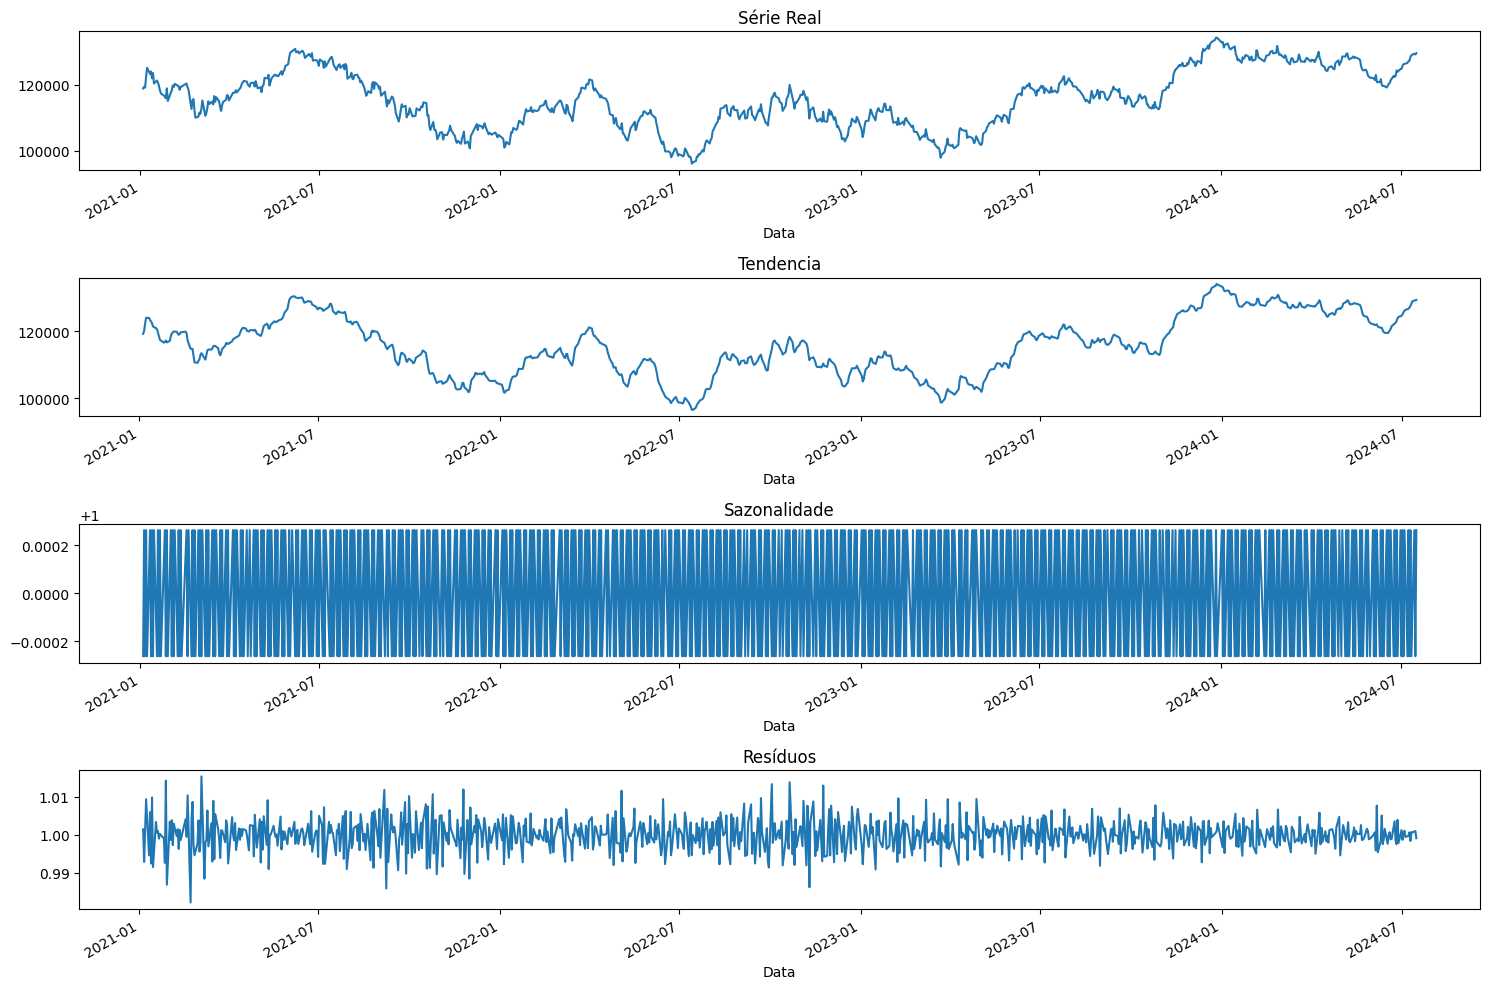

In [19]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10)) #cria as 4 figuras para plotarmos os gráficos
resultados.observed.plot(ax=ax1) #serie real
ax1.set_title('Série Real') #título do eixo 1
resultados.trend.plot(ax=ax2) #tendencia
ax2.set_title('Tendencia') #título do eixo 2
resultados.seasonal.plot(ax=ax3) #sazonalidade
ax3.set_title('Sazonalidade') #título do eixo 3
resultados.resid.plot(ax=ax4) #residuos
ax4.set_title('Resíduos') #título do eixo 4

plt.tight_layout() #Ajusta o padding entre os gráficos
plt.show() #mostrando os gráficos

Como esperado, vemos uma melhor concentração nos dados agora. Nossa tendencia é mais consistente e a sazonalidade é menor.

#Previsão dos valores de fechamento usando REGRESSÃO LINEAR

#Previsão dos valores de fechamento usando o modelo ARIMA

Passos para fazer uma previsão com ARIMA:
1. Visualizar a série temporal
2. Identificar se os dados são estacionários
3. Criar gráficos de correlação e auto-correlação
4. Criar o modelo ARIMA



##1. Visualizar a série temporal

Já fizemos isso acima, então simplesmente vamos colar o gráfico que criamos.

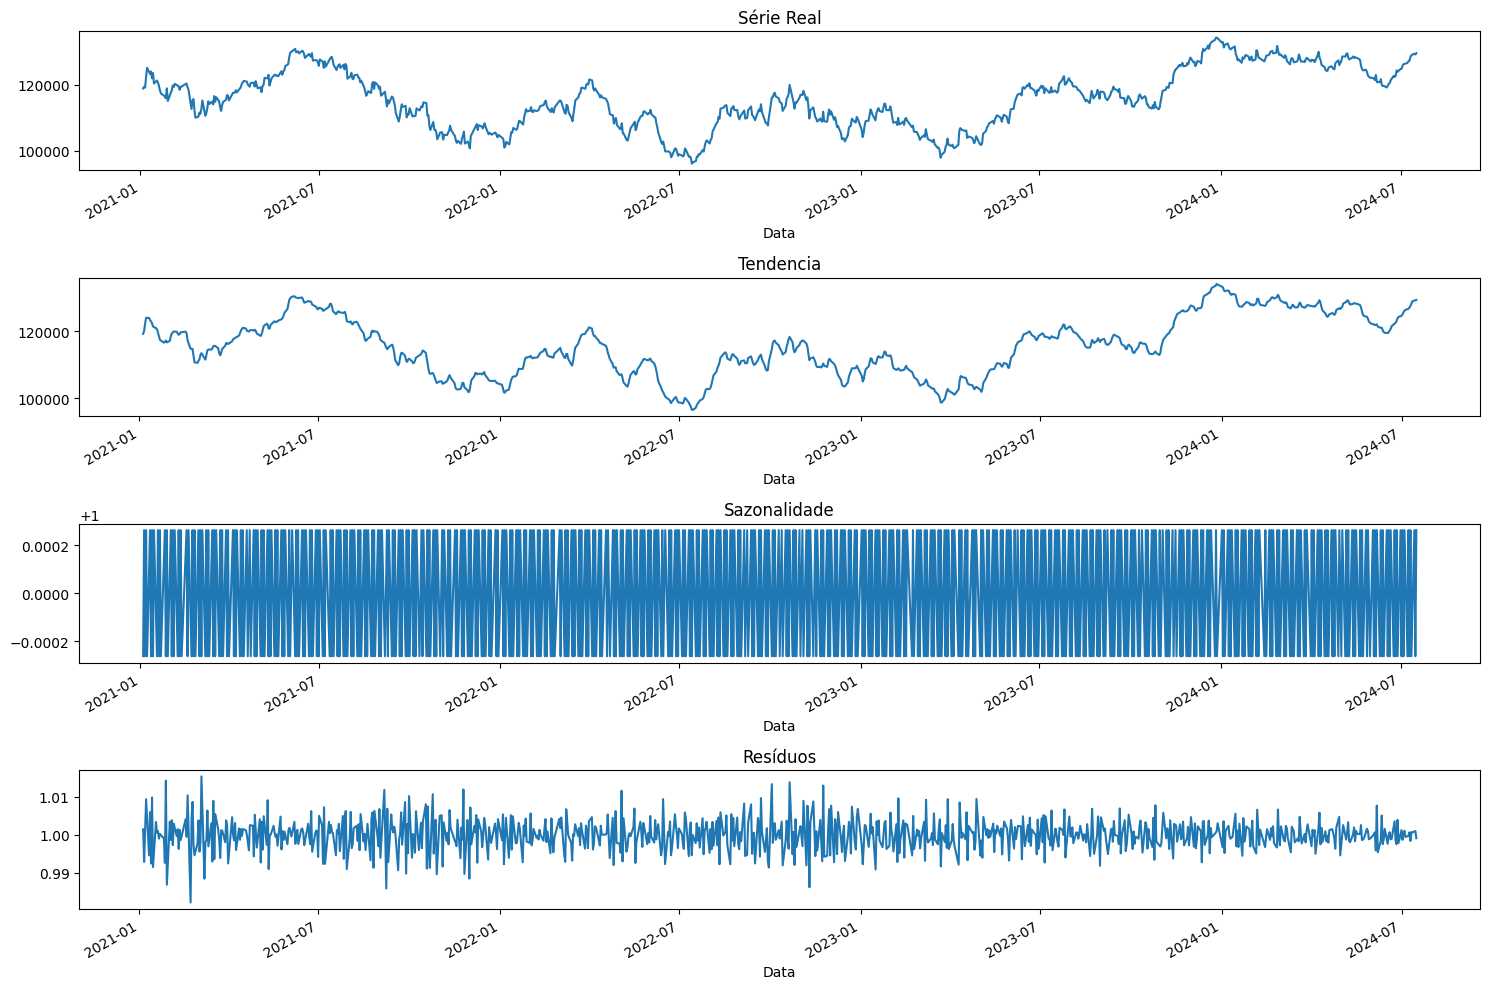

In [20]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10)) #cria as 4 figuras para plotarmos os gráficos
resultados.observed.plot(ax=ax1) #serie real
ax1.set_title('Série Real') #título do eixo 1
resultados.trend.plot(ax=ax2) #tendencia
ax2.set_title('Tendencia') #título do eixo 2
resultados.seasonal.plot(ax=ax3) #sazonalidade
ax3.set_title('Sazonalidade') #título do eixo 3
resultados.resid.plot(ax=ax4) #residuos
ax4.set_title('Resíduos') #título do eixo 4

plt.tight_layout() #Ajusta o padding entre os gráficos
plt.show() #mostrando os gráficos

##2. Identificar se os dados são estacionários

Agora precisamos validar se nossa série de dados é estacionária. Já vimos que ela ficou mais concentrada após os filtros que aplicamos, mas precisamos de estatística para termos certeza se ela é estacionária ou não.


*Estacionária ou não estacionária? Vamos fazer o teste de ADF (Augmented Dickey-Fuller)*

H0 - Hipótese nula (A série temporal NÃO é estacionária)

H1 - Hipótese alternativa (A série temporal é estacionária)

Vamos criar um gráfico da situação atual da nossa série, e pegar uma média móvel de 12 períodos.

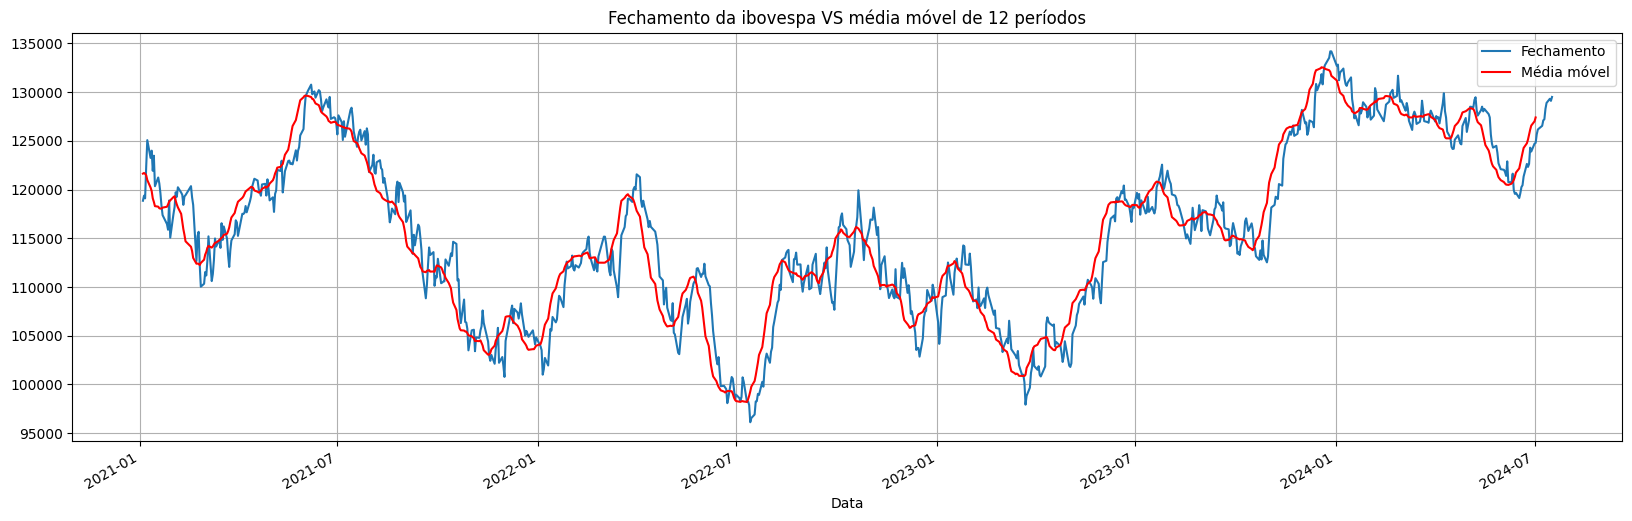

In [21]:
ma = df_ibovespa_limpo.rolling(12).mean() #pega uma média móvel a cada 12 períodos
f, ax = plt.subplots(figsize=(20, 6)) #indica o tamanho do gráfico
df_ibovespa_limpo.plot(ax=ax, y='Fechamento', label='Fechamento') #cria o gráfico de linhas do fechamento
ma.plot(ax=ax, y='Fechamento', color="red", label='Média móvel') #cria o gráfico de linhas da média móvel
plt.grid(True) #coloca grade no gráfico
plt.legend() #mostra a legenda
plt.title('Fechamento da ibovespa VS média móvel de 12 períodos') #adicionando um título ao gráfico
plt.show() #mostrando os gráficos

Como vimos no gráfico acima, fica claro que é bem provavél que nossa série não é estacionária, mas vamos comprovar isso estatísticamente usando o ADF abaixo:

In [22]:
X = df_ibovespa_limpo.Fechamento.values #pega apenas os números do fechamento
result = adfuller(X) #Atribui a função de adfuller a variavel result

print(f'ADF Statistic: {result[0]}') #printa o resultado de adf
print(f'p-value: {result[1]}') #printa o p-value

print(f'Valores críticos:') #printa os valores críticos
for key, value in result[4].items():
    print(f'{key}: {value}')

#Indica se a série é temporal ou não com base no resultado do p-value.
if result[1] <= 0.05:
    print("A série temporal é estacionária.")
else:
    print("A série temporal não é estacionária.")

ADF Statistic: -2.5707537835471928
p-value: 0.0991937636078401
Valores críticos:
1%: -3.4377943310889303
5%: -2.8648262173548456
10%: -2.5685198165973295
A série temporal não é estacionária.


Com um teste de 95% de confiança, podemos dizer portanto que nossa série NÃO é estacionária.

Mas para fazermos o ARIMA, precisamos de uma série estacionária, portanto teremos que converter essa série para estacionária.

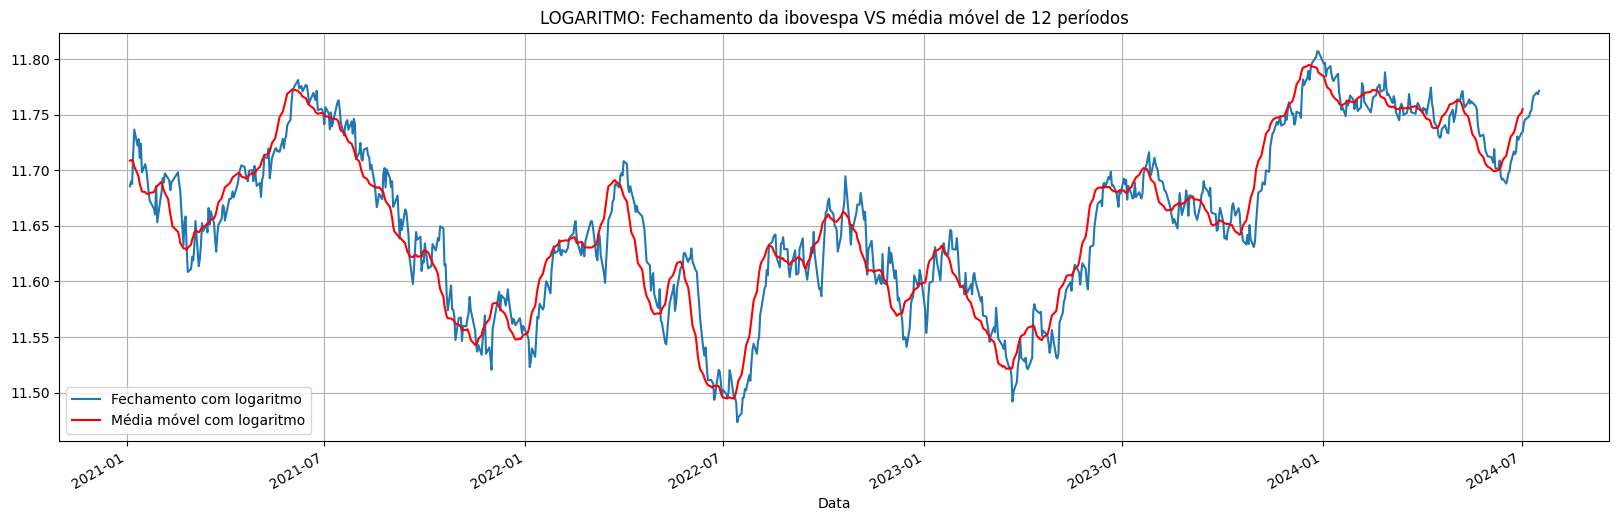

In [23]:
#Vamos usar logaritmo para fazer a conversão!
df_ibovespa_limpo_log = np.log(df_ibovespa_limpo) #aplicando o logaritmo
df_ibovespa_limpo_log_ma = df_ibovespa_limpo_log.rolling(12).mean() #pega uma média móvel a cada 12 períodos

f, ax = plt.subplots(figsize=(20, 6)) #indica o tamanho do gráfico
df_ibovespa_limpo_log.plot(ax=ax, y='Fechamento', label='Fechamento com logaritmo') #cria o gráfico de linhas do fechamento
df_ibovespa_limpo_log_ma.plot(ax=ax, y='Fechamento', color="red", label='Média móvel com logaritmo') #cria o gráfico de linhas da média móvel
plt.grid(True) #coloca grade no gráfico
plt.legend() #mostra a legenda
plt.title('LOGARITMO: Fechamento da ibovespa VS média móvel de 12 períodos') #adicionando um título ao gráfico
plt.show() #mostrando os gráficos

Como era de se esperar, a movimentação das linhas continua a mesma, mas os valores do eixo Y mudaram.

Agora vamos subtrair os dados transformados pelo log menos a média móvel para remover o componente de tendência de ambos.

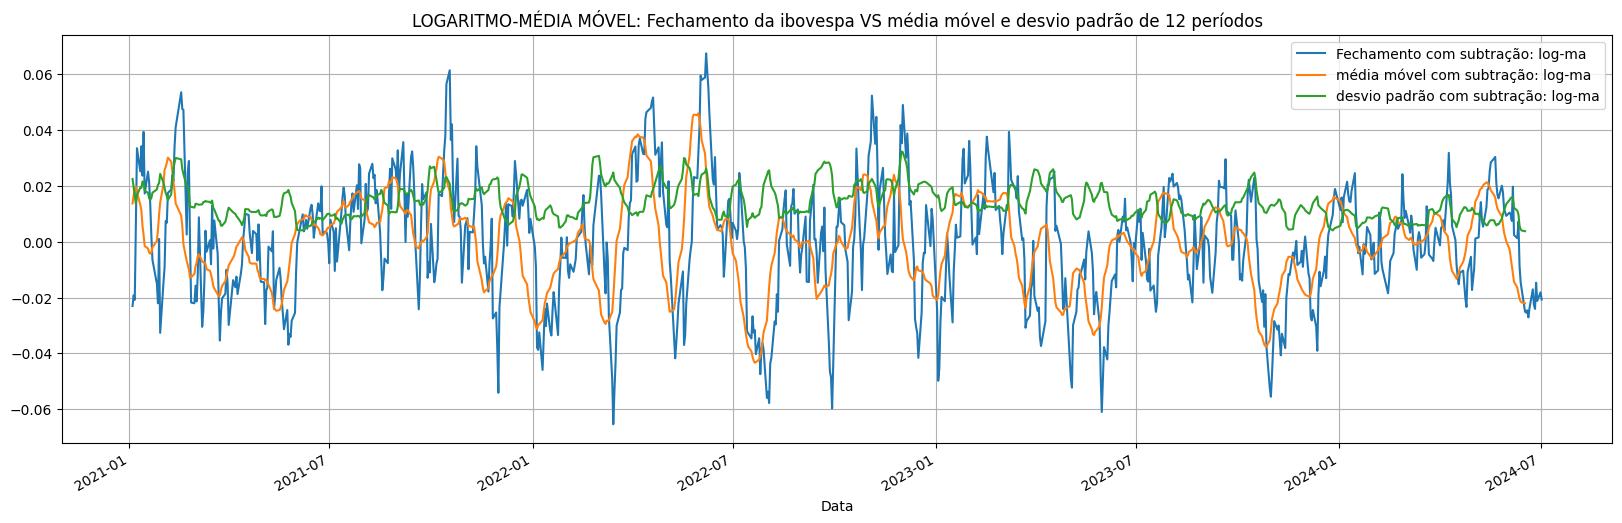

In [24]:
df_ibovespa_limpo_log_menos_ma = (df_ibovespa_limpo_log - df_ibovespa_limpo_log_ma).dropna() #Fazendo a subtração entre o log e a média móvel
ma_df_ibovespa_limpo_log_menos_ma = df_ibovespa_limpo_log_menos_ma.rolling(12).mean() #pega uma média móvel a cada 12 períodos
std_df_ibovespa_limpo_log_menos_ma = df_ibovespa_limpo_log_menos_ma.rolling(12).std() #vamos pegar também o desvio-padrão móvel a cada 12 períodos

f, ax = plt.subplots(figsize=(20, 6)) #indica o tamanho do gráfico
df_ibovespa_limpo_log_menos_ma.plot(ax=ax, y='Fechamento', label='Fechamento com subtração: log-ma') #cria o gráfico de linhas do fechamento
ma_df_ibovespa_limpo_log_menos_ma.plot(ax=ax, y='Fechamento', label='média móvel com subtração: log-ma') #cria o gráfico de linhas do fechamento
std_df_ibovespa_limpo_log_menos_ma.plot(ax=ax, y='Fechamento', label='desvio padrão com subtração: log-ma') #cria o gráfico de linhas do fechamento

plt.grid(True) #coloca grade no gráfico
plt.legend() #mostra a legenda
plt.title('LOGARITMO-MÉDIA MÓVEL: Fechamento da ibovespa VS média móvel e desvio padrão de 12 períodos') #adicionando um título ao gráfico
plt.show() #mostrando os gráficos

Podemos ver agora que nossos dados ficaram bem mais concentrados, esse é um forte indício de estacionaridade.

Vamos validar abaixo fazendo um novo teste de ADF:

In [25]:
X_s = df_ibovespa_limpo_log_menos_ma.Fechamento.values #pega apenas os números do fechamento
result = adfuller(X_s) #Atribui a função de adfuller a variavel result

print(f'ADF Statistic: {result[0]}') #printa o resultado de adf
print(f'p-value: {result[1]}') #printa o p-value

print(f'Valores críticos:') #printa os valores críticos
for key, value in result[4].items():
    print(f'{key}: {value}')

#Indica se a série é temporal ou não com base no resultado do p-value.
if result[1] <= 0.05:
    print("A série temporal é estacionária.")
else:
    print("A série temporal não é estacionária.")

ADF Statistic: -8.099961647667264
p-value: 1.307885099288633e-12
Valores críticos:
1%: -3.437888734710396
5%: -2.8648678385823603
10%: -2.5685419870524506
A série temporal é estacionária.


In [26]:
df_ibovespa_log = df_ibovespa_limpo_log_menos_ma #dando um nome mais amigável ao dataframe

Ótimo, nossa série é estacionária agora! Vamos para a próxima etapa!

##3. Criar gráficos de correlação e auto-correlação

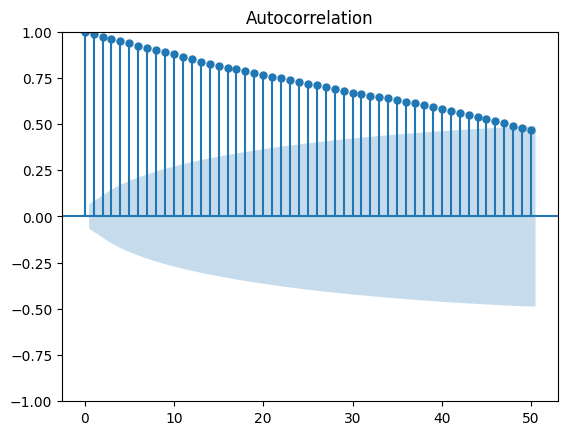

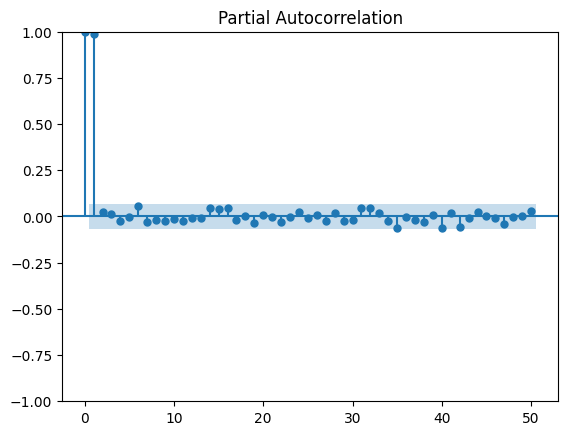

In [27]:
sm.graphics.tsa.plot_acf(df_ibovespa_limpo, lags=50) #cria o gráfico de autocorrelação com 50 lags
plt.show() #Para mostrar o gráfico de autocorrelação

sm.graphics.tsa.plot_pacf(df_ibovespa_limpo, lags=50) #cria o gráfico de autocorrelação parcial com 30 lags
plt.show() #Para mostrar o gráfico de autocorrelação

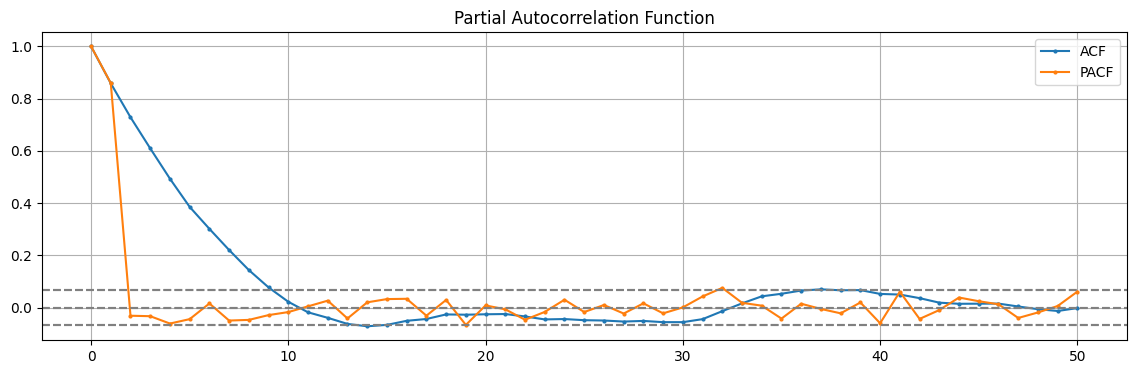

In [28]:
lag_acf = acf(df_ibovespa_log.dropna(), nlags=50)
lag_pacf = pacf(df_ibovespa_log.dropna(), nlags=50)

# Set desired figure size (width, height in inches)
figsize = (14, 4)  # Adjust these values as needed

# Create the figure with specified size
plt.figure(figsize=figsize)
plt.grid()

# Plot ACF (on the left half of the figure)

plt.plot(lag_acf, label='ACF', marker='o', markersize=2)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_ibovespa_log)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_ibovespa_log)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

# Plot PACF (on the right half of the figure)

plt.plot(lag_pacf, label='PACF', marker='o', markersize=2)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_ibovespa_log)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_ibovespa_log)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.legend()
plt.show()

##4. Criar o modelo ARIMA

In [29]:
df_ibovespa_log = df_ibovespa_limpo_log_menos_ma.copy() #dando um nome mais amigável ao dataframe
df_ibovespa_log.head()

,Fechamento
Data,
2024-07-02,-0.020709
2024-07-01,-0.018120
2024-06-28,-0.021216
2024-06-27,-0.014690
2024-06-26,-0.024045


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

<Axes: xlabel='Data'>

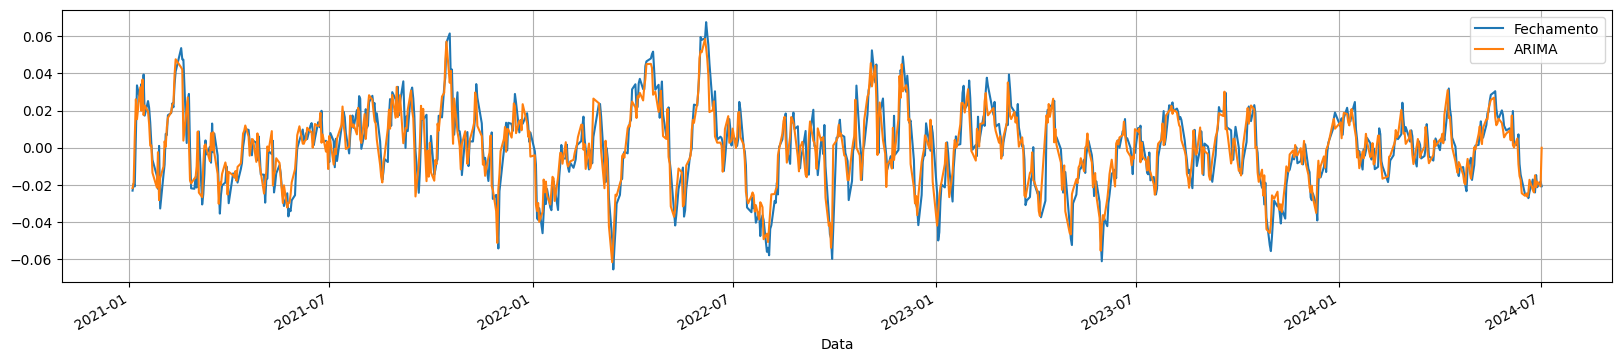

In [30]:
model = ARIMA(df_ibovespa_log, order=(50,1,49)) #creates the ARIMA model with the specified order
model_fit = model.fit() #fits the model to the data
df_ibovespa_log['ARIMA'] = model_fit.predict() #predicts the values using the fitted model
df_ibovespa_log.plot(figsize=(20,4), grid=True) #plots the actual and predicted values

In [31]:
actual = df_ibovespa_log['Fechamento']
predicted = df_ibovespa_log['ARIMA']

# Calculando o MAPE
mape = np.mean(np.abs((actual - predicted) / actual)) * 100
print(f'MAPE: {mape:.2f}%')

# Calculando o RMSE
rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f'RMSE: {rmse:.2f}')

# Calculando o R-squared
r2 = r2_score(actual, predicted)
print(f'R-squared: {r2:.2f}')

MAPE: 337.44%
RMSE: 0.01
R-squared: 0.75


Outros testes:

order=(6,1,11)
MAPE: 378.75%
RMSE: 0.01
R-squared: 0.74

order=(11,1,11)
MAPE: 362.94%
RMSE: 0.01
R-squared: 0.74

order=(11,1,20)
MAPE: 364.08%
RMSE: 0.01
R-squared: 0.74

order=(50,1,49)
MAPE: 337.44%
RMSE: 0.01
R-squared: 0.75

# Modelo preditivo com LSTM

In [ ]:
pip install keras tensorflow

In [1]:
import pandas as pd


ibov = pd.read_csv("dados-2020-2024.csv", sep=",")


# Convert 'Data' to datetime and check for missing values
ibov['Data'] = pd.to_datetime(ibov['Data'], format='%d.%m.%Y')
# Settar indice em Data e dar sort
ibov.set_index('Data', inplace=True)
ibov.sort_index(inplace=True)

# Converting 'Vol.' to numeric (removing 'M' and 'K' and converting to millions and thousands respectively)
ibov['Vol.'] = ibov['Vol.'].str.replace('B', 'e9').str.replace('M', 'e6').str.replace('K', 'e3').str.replace(',', '').astype(float)
# Converting 'Var%' to numeric (removing '%' and converting to float)
ibov['Var%'] = ibov['Var%'].str.replace('%', '').str.replace(',', '.').astype(float)



ibov.tail()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2024-07-11,128.294,127.221,128.326,127.221,7.970000e+11,0.85
2024-07-12,128.897,128.293,129.015,128.002,7.210000e+11,0.47
2024-07-15,129.321,128.898,129.485,128.723,5.830000e+11,0.33
2024-07-16,129.110,129.322,129.521,128.761,6.820000e+11,-0.16
2024-07-17,129.510,129.112,129.658,128.741,6.670000e+08,0.31


In [2]:
# Filtrando ultimos 2 anos
ibov_slice = ibov.query("Data >= '2022-01-01'")
ibov_slice.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2022-01-03,103.922,104.823,106.125,103.413,1.113000e+09,-0.86
2022-01-04,103.514,103.922,104.276,103.096,1.149000e+09,-0.39
2022-01-05,101.006,103.514,103.514,100.850,1.288000e+09,-2.42
2022-01-06,101.561,101.006,102.235,101.000,1.175000e+09,0.55
2022-01-07,102.719,101.561,102.719,101.104,1.173000e+09,1.14


In [3]:
# Separando os dados em treino e teste
train_data, test_data = ibov_slice[0:int(len(ibov_slice)*0.9)], ibov_slice[int(len(ibov_slice)*0.9):]
train_data

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2022-01-03,103.922,104.823,106.125,103.413,1.113000e+09,-0.86
2022-01-04,103.514,103.922,104.276,103.096,1.149000e+09,-0.39
2022-01-05,101.006,103.514,103.514,100.850,1.288000e+09,-2.42
2022-01-06,101.561,101.006,102.235,101.000,1.175000e+09,0.55
2022-01-07,102.719,101.561,102.719,101.104,1.173000e+09,1.14
...,...,...,...,...,...,...
2024-04-10,128.054,129.872,129.872,127.732,1.045000e+09,-1.41
2024-04-11,127.396,128.051,128.051,127.069,8.880000e+08,-0.51
2024-04-12,125.946,127.396,127.640,125.635,1.025000e+09,-1.14


In [4]:
train = train_data.iloc[:, 0:1].values # selecionando apenas a coluna de fechamento
len(train)

571

In [5]:
# Importando bibliotecas necessárias
from sklearn.preprocessing import MinMaxScaler  # Para escalonamento de dados
import numpy as np  # Biblioteca para operações de álgebra linear

# Inicializando o objeto MinMaxScaler
scaler = MinMaxScaler()
# Aplicando o escalonamento aos dados de treino. 
# Isso transforma os dados para que fiquem dentro do intervalo [0, 1], o que é útil para melhorar a performance do modelo.
train_scaled = scaler.fit_transform(train)

# Definindo o número de timesteps. 
# timesteps é o número de pontos de tempo anteriores usados para prever o próximo ponto.
timesteps = 7

# Inicializando listas para armazenar os dados de entrada (X_train) e saída (y_train) do modelo
X_train = []
y_train = []

# Loop para criar sequências de entrada e saídas correspondentes
for i in range(timesteps, train.shape[0]):
    # Para cada ponto no conjunto de dados, exceto os últimos 'timesteps' pontos,
    # cria uma sequência de 'timesteps' pontos anteriores como entrada
    X_train.append(train_scaled[i-timesteps:i, 0])  # Adicionando a sequência de entrada

    # O valor imediatamente seguinte a essa sequência é usado como saída
    y_train.append(train_scaled[i, 0])  # Adicionando o valor de saída correspondente

# Convertendo as listas para arrays NumPy para uso em modelos de aprendizado de máquina
X_train, y_train = np.array(X_train), np.array(y_train)

# Resumo: Este código está preparando os dados de entrada e saída para treinar um modelo de séries temporais.
# Cada entrada é uma sequência de 7 pontos de dados, e a saída correspondente é o ponto de dados
# que segue esses 7 pontos na série.
X_train, y_train

(array([[0.20489586, 0.1941796 , 0.12830615, ..., 0.17329866, 0.1529693 ,
         0.20113992],
        [0.1941796 , 0.12830615, 0.14288341, ..., 0.1529693 , 0.20113992,
         0.2512279 ],
        [0.12830615, 0.14288341, 0.17329866, ..., 0.20113992, 0.2512279 ,
         0.24713051],
        ...,
        [0.81939957, 0.82228876, 0.80566281, ..., 0.88695401, 0.83873086,
         0.82144827],
        [0.82228876, 0.80566281, 0.85982192, ..., 0.83873086, 0.82144827,
         0.78336354],
        [0.80566281, 0.85982192, 0.88695401, ..., 0.82144827, 0.78336354,
         0.76728916]]),
 array([0.2512279 , 0.24713051, 0.28384945, 0.26929845, 0.27702046,
        0.31234733, 0.34095028, 0.33674783, 0.31035117, 0.36989468,
        0.39839256, 0.4331416 , 0.41470333, 0.42084942, 0.44932104,
        0.41428309, 0.40908255, 0.42350222, 0.41696215, 0.4232133 ,
        0.42917553, 0.45299819, 0.45835632, 0.46694508, 0.49134557,
        0.50061724, 0.45720064, 0.44018071, 0.40984425, 0.44049589,
 

In [21]:
import numpy as np
from numpy.random import seed

# Reshaping X_train for Neural Network Input
# X_train é um array NumPy contendo os dados de entrada para o modelo de rede neural.
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# Esta linha remodela X_train para a forma (número de amostras, timesteps, número de características por timestep).
# Em redes neurais recorrentes como LSTM, espera-se que a entrada seja um tensor 3D com essa forma.
# Aqui, estamos configurando apenas uma característica por timestep (daí o '1' no final).

# Definindo uma semente para reprodutibilidade
seed(20240729)


In [22]:
# Para esse modelo LSTM inicial, usaremos a biblioteca Keras
from keras.models import Sequential  
from keras.layers import Dense       
from keras.layers import LSTM        
from keras.layers import Dropout     

# Importando a função para escalonamento de dados
from sklearn.preprocessing import MinMaxScaler

# Preparação dos dados: Escalonamento dos dados de treinamento para o intervalo [0, 1]
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)  # Escalonando os dados de treinamento

# Definição dos timesteps, que são os passos temporais utilizados nas sequências de entrada
X_train = []  # Lista para armazenar os dados de entrada
y_train = []  # Lista para armazenar os rótulos (valores de saída esperados)

# Estruturação dos dados de treinamento para se adequarem ao modelo de rede neural recorrente
for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0])  # Adicionando a sequência de timesteps anteriores
    y_train.append(train_scaled[i, 0])              # Adicionando o valor atual como rótulo

# Convertendo as listas em arrays NumPy para uso no modelo de aprendizado de máquina
X_train, y_train = np.array(X_train), np.array(y_train)

# Construção do modelo sequencial usando Keras
model = Sequential()

# Adicionando camadas à rede neural para previsão de séries temporais

# Adicionando a primeira camada LSTM (Long Short-Term Memory)
model.add(LSTM(
    units = 50,  # Número de unidades (neurônios) na camada, um indicador da "capacidade" da camada
    return_sequences = True,  # Mantém as sequências completas como saída para a próxima camada LSTM
    input_shape = (X_train.shape[1], 1)  # Define a forma da entrada (número de timesteps e recursos por timestep)
))

# A camada LSTM é crucial para modelar dependências em sequências temporais, como preços de ações.
# Ela é capaz de aprender a partir de longas sequências de dados, mantendo informações importantes e esquecendo as irrelevantes.

# Adicionando a camada de Dropout para regularização
model.add(Dropout(0.25))  # Descarta 25% das unidades aleatoriamente para prevenir overfitting

# O Dropout é uma técnica de regularização eficaz para reduzir o overfitting em redes neurais, 
# especialmente útil em redes profundas e complexas.

# Adicionando mais camadas LSTM e Dropout
# Essas camadas adicionais aumentam a capacidade do modelo de aprender padrões complexos nos dados.

model.add(LSTM(units = 50, return_sequences = True))  # Outra camada LSTM
model.add(Dropout(0.25))  # Dropout aumentado para 25% para maior regularização

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))  # Dropout de 20%

# A última camada LSTM não tem return_sequences = True, 
# isso indica que a sequência completa não é mais necessária nas saídas
model.add(LSTM(units = 50))  # Última camada LSTM

# Adicionando outra camada de Dropout
model.add(Dropout(0.25))  # Dropout de 25%

# A estrutura de múltiplas camadas LSTM seguidas por Dropout é uma configuração comum em tarefas de previsão de séries temporais.
# Isso permite que o modelo capture padrões complexos e de longo alcance nos dados, 
# enquanto o Dropout ajuda a garantir que o modelo não se ajuste excessivamente aos dados de treinamento.

# Adicionando a camada de saída
model.add(Dense(units = 1))

# Compilando a rede neural recorrente
# Usando 'adam' como otimizador e 'mean_squared_error' como função de perda
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Treinando o modelo com os dados de treinamento
model.fit(X_train, y_train, epochs = 40, batch_size = 32)

Epoch 1/40


c:\Users\chris\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.2068
Epoch 2/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0364
Epoch 3/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0179
Epoch 4/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0115
Epoch 5/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0109
Epoch 6/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0113
Epoch 7/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0103
Epoch 8/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0097
Epoch 9/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0086
Epoch 10/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0092
Epoch 11/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0103
Epoch 12/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0092
Epoch 13/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0077
Epoch 14/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0093
Epoch 15/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0084
Epoch 16/40
18/18 ━━━━━━━━━━━━

In [8]:
# Preparação dos dados de teste
# Extraindo os preços reais das ações (valor de fechamento) do conjunto de teste
real_stock_price = test_data.iloc[:,0:1].values

# Combinando os dados de treinamento e teste para formar sequências de entrada para a previsão
combine = pd.concat((train_data['Último'], test_data['Último']), axis = 0)

# Preparando as entradas de teste, incluindo os preços das ações dos últimos timesteps
test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

# Processando os dados de teste da mesma forma que os dados de treinamento
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Realizando previsões com o modelo treinado
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


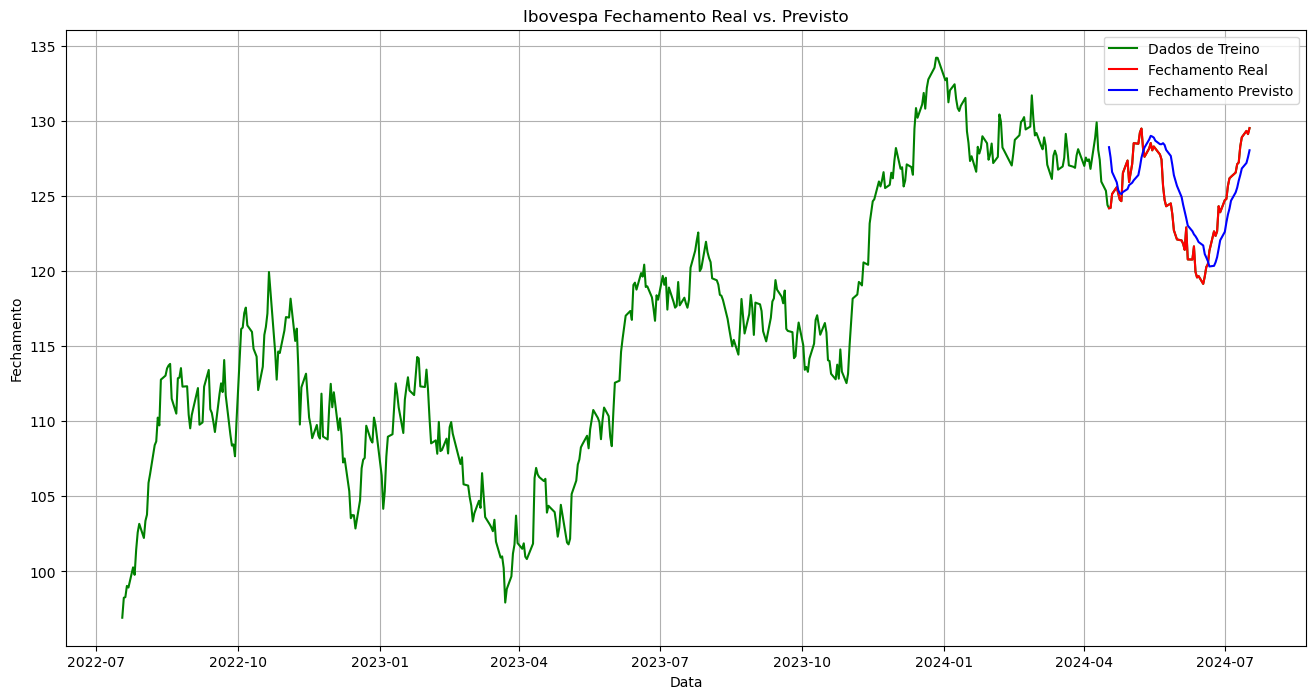

MSE: 4.143595843354774
MAE: 1.7669421072006233
RMSE: 2.035582433446205


In [30]:
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

close_up_df = 500

plt.figure(figsize=(16,8))
plt.plot(ibov.index[-close_up_df:], ibov['Último'].tail(close_up_df), color='green', label = 'Dados de Treino')
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Fechamento Real')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Fechamento Previsto')
plt.title('Ibovespa Fechamento Real vs. Previsto')
plt.xlabel('Data')
plt.ylabel('Fechamento')
plt.legend()
plt.grid(True)
plt.show()

mse = mean_squared_error(real_stock_price, predicted_stock_price)
print('MSE: '+str(mse))
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('RMSE: '+str(rmse))

In [26]:
# Inicializando as variáveis
size = len(ibov)
array_last_7_days = ibov['Último'][size - 7: size].values
array_last_7_days = array_last_7_days.reshape(-1,1)
array_last_7_days = scaler.transform(array_last_7_days)

# Definindo o intervalo de datas para as previsões
start_date = '2024-07-10'
end_date = '2024-07-17'
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Inicializando a lista para armazenar as previsões
predictions = []

# Loop para gerar previsões para cada data no intervalo
for current_date in date_range:
    # Fazendo a previsão para o próximo dia
    future_predict = model.predict(np.array([array_last_7_days]))
    future_predict = scaler.inverse_transform(future_predict)

    # Atualizando a lista de previsões
    predictions.append(future_predict[0, 0])

    # Transformando o valor previsto de volta para a escala original antes de atualizar a matriz
    future_predict_scaled = scaler.transform(future_predict)


    # Preparando os dados dos últimos 7 dias para a próxima iteração
    array_last_7_days = np.append(array_last_7_days[1:], future_predict_scaled).reshape(-1, 1)

# Convertendo as previsões para um DataFrame para facilitar a visualização e análise
forecast = pd.DataFrame(data={'Data': date_range, 'Previsto': predictions})

# Exibindo as previsões
print(forecast)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
        Data    Previsto
0 2024-07-10  130.942108
1 2024-07-11  131.426208
2 2024-07-12  131.982040
3 2024-07-13  132.461548
4 2024-07-14  132.959610
5 2024-07-15  133.501205
6 2024-07-16  134.169861
7 2024-07-17  134.843460


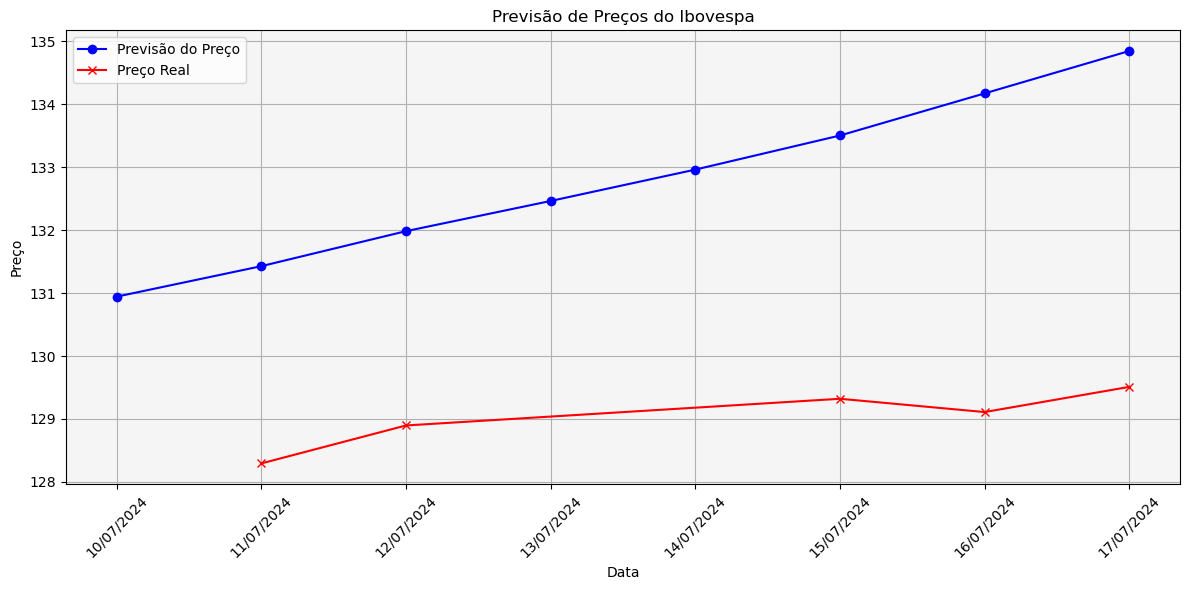

In [31]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# inputando dados reais para comparação

data = {
    'Data': ['2024-07-11', '2024-07-12', '2024-07-15', '2024-07-16', '2024-07-17'],
    'Preço': [128.294, 128.897, 129.321, 129.110, 129.510]
}

# Convertendo para DataFrame
actual_prices = pd.DataFrame(data)
actual_prices['Data'] = pd.to_datetime(actual_prices['Data'], format='%Y-%m-%d')
actual_prices.set_index('Data', inplace=True)
actual_prices.sort_index(inplace=True)
actual_prices, forecast 

# Plotando os preços reais e previstos
plt.figure(figsize=(12, 6))

plt.plot(forecast['Data'], forecast['Previsto'], color='blue', marker='o', linestyle='-', label='Previsão do Preço')
plt.plot(actual_prices.index, actual_prices['Preço'], color='red', marker='x', linestyle='-', label='Preço Real')
date_format = mdates.DateFormatter('%d/%m/%Y')
plt.gca().xaxis.set_major_formatter(date_format)


plt.title('Previsão de Preços do Ibovespa')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()

plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
# alterando cor de fundo
plt.gca().set_facecolor('whitesmoke')
plt.show()